# Problema para selección de candidatos QM 2023

**Contexto**

Un determinado puerto marítimo tiene 3 zonas de descarga C1, C2 y C3; 2 zonas de carga S1, S2; 2 depósitos para almacenaje D1, D2 y 3 terminales T1, T2 y T3. Cada instante de tiempo se reciben y solicitan contenedores vacíos, que se redistribuyen para satisfacer la oferta y la demanda de comercio ultramarino.

## Imports

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from dwave.system import LeapHybridCQMSampler
from dimod import QuadraticModel, ConstrainedQuadraticModel, Binary, Integer

# Replace with your DWave token
os.environ['DWAVE_API_TOKEN'] = 'DEV-02d687c5521a014df6c14e8a3ae5694cb67d5a8f'

## Parámetros

In [339]:
#zonas
zonas_de_descarga = ['C1', 'C2', 'C3']
zonas_de_carga = ['S1', 'S2']
zonas_de_almacenaje = ['D1', 'D2']
terminales = ['T1', 'T2', 'T3']

periods = [0, 1]   #calculamos el problema para dos periodos
max_cap = 20   #capacidades máximas de almacenaje tanto en terminales como en depósitos

#costes de almacenaje por contenedor
cost_terminales = [20, 30, 25]   #coste de la terminal 1,2,3
cost_almacenes = [22, 28]   #coste de almacenes

# Matrices de coste de transporte
CT = [[14,15,12], [15,17,12], [20,19,17]]   #descarga-terminal
CD = [[12,10], [19,12], [16,18]]   #descarga-depósito
TS = [[14,15], [18,17], [12,20]]   #terminal-carga
DS = [[11,17], [12,14]]   #depósito-carga
TT = [[0,15,18], [15,0,12], [17,16,0]]   #terminal-terminal
DD = [[0,18], [16,0]]   #depósito-depósito
TD = [[16,15], [14,17], [13,16]]   #terminal-depósito
DT = [[18,16,17], [14,17,18]]   #depósito-terminal

## Variables

Vamos a definir dos tipos de variables:
1. Aquellas que representan la cantidad de contenedores vacíos que se envían de una zona a otra. Estas variables van a tener la siguiente estructura: 'supply_x_y_z' que significa que en el tiempo z se han enviado contenedores de x a y.
2. El número de contenedores vacíos que hay en terminales y almacenes. Estas variables tienen la siguiente estructura: 'contains_x_z' que significa que la zona x tiene cierto numero de contenedores en el tiempo z.

Por lo tanto, las variables deben ser integers.

In [340]:
# container supplied by descarga c to terminal t at time i
ct = {(x, y, z): Integer('supply_{}_{}_{}'.format(x, y, z)) for x in zonas_de_descarga for y in terminales for z in periods}

# container supplied by descarga c to almacen d at time i
cd = {(x, y, z): Integer('supply_{}_{}_{}'.format(x, y, z)) for x in zonas_de_descarga for y in zonas_de_almacenaje for z in periods}

# container supplied by terminal t to carga s at time i
ts = {(x, y, z): Integer('supply_{}_{}_{}'.format(x, y, z)) for x in terminales for y in zonas_de_carga for z in periods}

# container supplied by almacen d to carga s at time i
ds = {(x, y, z): Integer('supply_{}_{}_{}'.format(x, y, z)) for x in zonas_de_almacenaje for y in zonas_de_carga for z in periods}

# container supplied by terminal t to terminal t at time i
tt = {(x, y, z): Integer('supply_{}_{}_{}'.format(x, y, z)) for x in terminales for y in terminales for z in periods if x != y}

# container supplied by almacen d to almacen d at time i
dd = {(x, y, z): Integer('supply_{}_{}_{}'.format(x, y, z)) for x in zonas_de_almacenaje for y in zonas_de_almacenaje for z in periods if x != y}

# container supplied by terminal t to almacen d at time i
td = {(x, y, z): Integer('supply_{}_{}_{}'.format(x, y, z)) for x in terminales for y in zonas_de_almacenaje for z in periods}

# container supplied by almacen d to terminal t at time i
dt = {(x, y, z): Integer('supply_{}_{}_{}'.format(x, y, z)) for x in zonas_de_almacenaje for y in terminales for z in periods}

# container at terminal t at time i
T = {(x, z): Integer('contains_{}_{}'.format(x, z)) for x in terminales for z in periods}

# container at almacen d at time i
D = {(x, z): Integer('contains_{}_{}'.format(x, z)) for x in zonas_de_almacenaje for z in periods}

## Función de coste

Los costes totales incluyen todos los costes de transporte (entre terminales, almacenes, zonas de carga y descarga) más los costes de almacenamiento (en los alamacenes y en las terminales). Para representar este problema, he decidido utilizar el ConstrainedQuadraticModel de DWave.

In [341]:
model = ConstrainedQuadraticModel()

In [342]:
operating_cost = QuadraticModel()

for i in periods:
    for c in range(len(zonas_de_descarga)):
        
        #coste de transporte de descarga a terminal
        for t in range(len(terminales)):
            operating_cost.update(CT[c][t] * ct[zonas_de_descarga[c],terminales[t],i])

        #coste de transporte de descarga a almacen
        for d in range(len(zonas_de_almacenaje)):
            operating_cost.update(CD[c][d] * cd[zonas_de_descarga[c],zonas_de_almacenaje[d],i])

    for t in range(len(terminales)):

        #coste de almacenamiento en terminal
        operating_cost.update(cost_terminales[t] * T[terminales[t], i])

        for s in range(len(zonas_de_carga)):

            #coste de transporte de terminal a carga
            operating_cost.update(TS[t][s] * ts[terminales[t],zonas_de_carga[s],i])

        for t1 in range(len(terminales)):
            
            if t1 == t:
                continue
            #coste de transporte de terminal a terminal
            operating_cost.update(TT[t][t1] * tt[terminales[t],terminales[t1],i])
            operating_cost.update(TT[t1][t] * tt[terminales[t1],terminales[t],i])

        for d in range(len(zonas_de_almacenaje)):

            #coste de transporte de terminal a almacen
            operating_cost.update(TD[t][d] * td[terminales[t],zonas_de_almacenaje[d],i])

    for d in range(len(zonas_de_almacenaje)):

        #coste de almacenamiento de almacen
        operating_cost.update(cost_almacenes[d] * D[zonas_de_almacenaje[d], i])

        for s in range(len(zonas_de_carga)):

            #coste de transporte de almacen a carga
            operating_cost.update(DS[d][s] * ds[zonas_de_almacenaje[d],zonas_de_carga[s],i])

        for t in range(len(terminales)):

            #coste de transporte de almacen a terminal
            operating_cost.update(DT[d][t] * dt[zonas_de_almacenaje[d],terminales[t],i])

        for d1 in range(len(zonas_de_almacenaje)):
            if d1 == d:
                continue
            #coste de transporte de almacen a almacen
            operating_cost.update(DD[d][d1] * dd[zonas_de_almacenaje[d],zonas_de_almacenaje[d1],i])
            operating_cost.update(DD[d1][d] * dd[zonas_de_almacenaje[d1],zonas_de_almacenaje[d],i])

In [343]:
model.set_objective(operating_cost)

## Restricciones

Las capacidades máximas de almacenaje tanto en terminales como en depósitos son de 20 contenedores

In [344]:
for i in periods:
    for zona in (zonas_de_almacenaje):
        model.add_constraint(D[zona, i] >= 0)
        model.add_constraint(D[zona, i] <= max_cap)

    for zona in (terminales):
        model.add_constraint(T[zona, i] >= 0)
        model.add_constraint(T[zona, i] <= max_cap)

En un cierto instante de tiempo, cada depósito y cada terminal, excepto la T2, tienen un contenedor vacío en stock.

In [345]:
for zona in (zonas_de_almacenaje):
    model.add_constraint(D[zona, 0] == 1)

for zona in (terminales):
    if zona == 'T2':
        model.add_constraint(T[zona, 0] == 0)
    else:
        model.add_constraint(T[zona, 0] == 1)

En ese mismo instante, cada zona de carga y la terminal T2 reclaman cada una un contenedor vacío para importación ultramarítima, así como cada zona de descarga provee de un contenedor vacío proveniente de comercio de ultra mar.

In [346]:
#cada zona de carga reclama un contenedor vacio
tsds = {**ts, **ds}
s1 = [key for key, value in tsds.items() if key[2] == 1 and key[1] == 'S1']
s2 = [key for key, value in tsds.items() if key[2] == 1 and key[1] == 'S2']

sum = QuadraticModel()
for i in s1:
    sum += tsds[i]
model.add_constraint(sum == 1, label = 'zona de carga S1 reclama un contenedor')

sum = QuadraticModel()
for i in s2:
    sum += tsds[i]
model.add_constraint(sum == 1, label = 'zona de carga S2 reclama un contenedor')

'zona de carga S2 reclama un contenedor'

In [347]:
#la T2 reclama un contenedor vacio
ctttdt = {**ct, **tt, **dt}
keys_with_zero = [key for key, value in ctttdt.items() if key[2] == 1 and key[1] == 'T2']
sum = QuadraticModel()
for i in keys_with_zero:
    sum += ctttdt[i]

model.add_constraint(sum == 1, label = 'T2 reclama un contenedor')

'T2 reclama un contenedor'

Balance de contenedores en las terminales

$T^i_{t} = T^{i-1}_{t} +\sum dt ^i +\sum ct ^i+ \sum t{t'} ^i  -\sum t't^i - \sum td ^i - \sum ts ^i $

In [348]:
for t in (terminales):
    sum = QuadraticModel()
    for i in range(1, len(periods)):
        sum += T[t, i] - T[t, i-1]
        for s in (zonas_de_carga):
            sum += ts[t, s, i]

        for c in (zonas_de_descarga):
            sum -= ct[c, t, i]

        for t1 in (terminales):

            if t == t1:
                continue
            sum += tt[t, t1, i]
            sum -= tt[t1, t, i]

        for d in (zonas_de_almacenaje):
            sum += td[t, d, i]
            sum -= dt[d, t, i]


    model.add_constraint(sum == 0, label = f'balance en terminal {t}')

Balance de contenedores en los almacenes

$D^i_{d} = D^{i-1}_{d} +\sum td ^i +\sum cd ^i+ \sum d{d'} ^i  -\sum d'd^i - \sum dt ^i - \sum ds ^i $

In [349]:
for d in (zonas_de_almacenaje):
    sum = QuadraticModel()
    for i in range(1, len(periods)):
        sum += D[d, i] - D[d, i-1]
        for s in (zonas_de_carga):
            sum += ds[d, s, i]

        for c in (zonas_de_descarga):
            sum -= cd[c, d, i]

        for t in (terminales):
            sum += dt[d, t, i]
            sum -= td[t, d, i]

        for d1 in (zonas_de_almacenaje):
            if d == d1:
                continue
            sum -= dd[d, d1, i]
            sum += dd[d1, d, i]

    model.add_constraint(sum == 0, label = f'balance en almacenes {d}')

## Resolver el modelo

In [350]:
sampler = LeapHybridCQMSampler()

Minimum energy 183.0


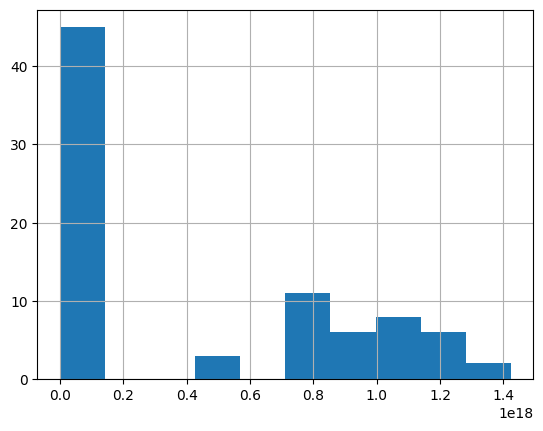

In [351]:
raw_sampleset = sampler.sample_cqm(model)
feasible_sampleset = raw_sampleset.filter(lambda d: d.is_feasible)
feasible_sampleset_csv = feasible_sampleset.to_pandas_dataframe(True)
feasible_sampleset_csv.energy.hist()
print(f'Minimum energy {feasible_sampleset_csv.energy.min()}')

In [352]:
# Calculate the number of feasible solutions in the feasible_sampleset
num_feasible = len(feasible_sampleset)

# Check if there are feasible solutions
if num_feasible > 0:
    # If there are feasible solutions, truncate the feasible_sampleset to the best 10 feasible solutions
    best_samples = feasible_sampleset.truncate(min(10, num_feasible))
else:
    # If there are no feasible solutions, truncate the original samples set to the best 10 samples
    best_samples = feasible_sampleset.truncate(10)

# Get the sample associated with the first entry in the best_samples set
best_sample = best_samples.first.sample

In [353]:
best_sample
filtered_dict = {key: value for key, value in best_sample.items() if value >= 1}
filtered_dict

{'contains_D1_0': 1.0,
 'contains_D1_1': 1.0,
 'contains_D2_0': 1.0,
 'contains_T1_0': 1.0,
 'contains_T1_1': 1.0,
 'contains_T3_0': 1.0,
 'supply_D2_T2_1': 1.0,
 'supply_T2_S2_1': 1.0,
 'supply_T3_S1_1': 1.0}

La D2 envia a T2, la T3 envia a S1, la T2 envia a la S2.